# Procesamiento Adaptativo de Señales Aleatorias
# Trabajo Práctico N°2 - Filtro óptimo
## Grupo 3
* Santiago Arribere
* Matías Francois
* Joaquín Gaytan
* Pablo Scheinfeld

## Notebook #2 - Implementación del filtro
En esta notebook se busca estimar la función transferencia de una habitación determinada empleando filtrado óptimo. Para lograr esto, se utilizarán las señales de prueba detalladas en la notebook *tp2_signals*.

# Filtro óptimo
Para el cálculo del filtro óptimo se emplea la ecuación de Wiener-Hopf, descrita a continuación.

$$R \vec{w_o} =\vec{p}$$

Para encontrar los coeficientes óptimos $\vec{w_0}$ se podría invertir la matriz de autocorrelación $R$, escalando a un problema de complejidad $O(n^3)$. Sin embargo, al ser $R$ una matriz toeplitz, es posible emplear el algoritmo recursivo de Levinson-Durbin. De esta forma, se disminuye considerablemente el tiempo de cálculo, reduciendo la complejidad a  $O(n^2)$. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sps
from IPython.display import Audio
from scipy.io import wavfile
from scipy import linalg, hamming
from scipy.fft import fft, fftfreq
from time import time as pytime

In [2]:
from helper import *

In [3]:
# Define file path dict
base = '..'
record_base = base + '/assets/recorded_sounds/wavs/'
original_base = base + '/assets/test_signals/'
audios_dict = {
    # AudioType: (recorded, original)
    'song': 'darkside.wav',
    'voice': 'whereiam.wav',
    'linear sweep': 'linear.wav',
    'periodic linear sweep': 'multiple_lin.wav',
    'exp sweep': 'exponential.wav',
    'periodic exp sweep': 'multiple_exp.wav',
    'square': 'rectangular.wav',
    'wgn': 'white-noise.wav'
}

In [4]:
# Define samplerate for input signals
samplerate = 44100 # Hz

# Determinación del orden óptimo
A continuación, se estiman los coeficientes del filtro para la señal de barrido lineal en frecuencia. Se repite este proceso variando el orden del filtro, y registrando el MSE óptimo $J_o$ en cada iteración.

In [5]:
# Get best M for linear sweep
order = [(i*(10**j)) for j in range(1,4) for i in range(1,10)] + [10000, 12500, 20000]
errors_dict = {}
best = {'epsilon':1, 'type': None, 'order':None}
for k in audios_dict:
    jo, epsilon  = [], []
    # Get audio files
    o_rate, original = wavfile.read(original_base + audios_dict[k])
    r_rate, recorded = wavfile.read(record_base + audios_dict[k])
    
    original = original / 32767
    recorded = recorded / 32767

    original -= np.mean(original)
    recorded -= np.mean(recorded)
    
    # Align both signals
    original_shifted, response_shifted = sync_tracks(original, recorded)
    
    r, p, sigma = get_r_p(original_shifted, response_shifted)
    
    # Get the variance of the desier signal
    for i in order:
        wo,p1, j, e  = get_filter(r, p, i, sigma)
        jo.append(j)
        epsilon.append(e)
        if best['epsilon'] > e:
            best['epsilon'] = e
            best['type'] = k
            best['order'] = i

    errors_dict[k] = {'jo':jo, 'epsilon':epsilon}
    print(f'[{k}] Finished estimation')

[song] Finished estimation
[voice] Finished estimation
[linear sweep] Finished estimation
[periodic linear sweep] Finished estimation
[exp sweep] Finished estimation
[periodic exp sweep] Finished estimation
[square] Finished estimation
[wgn] Finished estimation


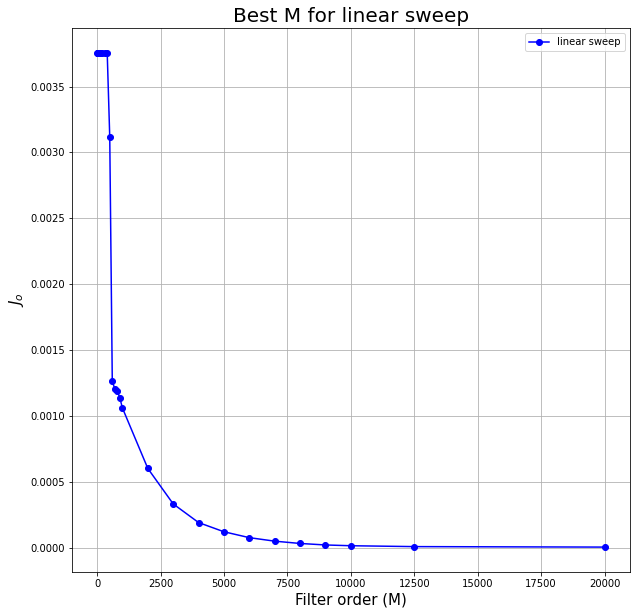

In [6]:
# Plot results
plt.figure(figsize=(10,10))
jo = errors_dict['linear sweep']['jo']
plt.plot(order, jo, label='linear sweep', marker='o', color='blue')
plt.grid(which='both', axis='both')
plt.ylabel('$J_o$', fontsize=15)
plt.xlabel('Filter order (M)', fontsize=15)
plt.title('Best M for linear sweep', fontsize=20)
plt.legend()
plt.show()

En el gráfico anterior, se aprecia como se mantiene constante el MSE óptimo para órdenes M bajos. A partir del orden $M=400$, el MSE disminuye formando un "codo" que concluye en una asíntota horizontal que se puede considerar constante a partir de orden $M=10000$.

Si se estuviera utilizando inversión matricial convencional para el cálculo de los coeficientes óptimos $\vec{w_o}$, sería prudente fijar el órden en $M=10000$ para evitar que el cálculo escale notablemente. Como en este caso se emplea el método de Levinson-Durbin, se elige adpoptar el orden máximo alcanzado ($M=20000$) de forma tal de lograr el error más bajo, no siendo afectado apreciablemnete el tiempo de procesamiento.

A continuación se grafica el MSE normalizado ($\epsilon$), que permite comparar la calidad de las estimaciones de la respuesta impulsiva utilizando como referencia las distintas señales propuestas en la notebook *tp2_signals*.

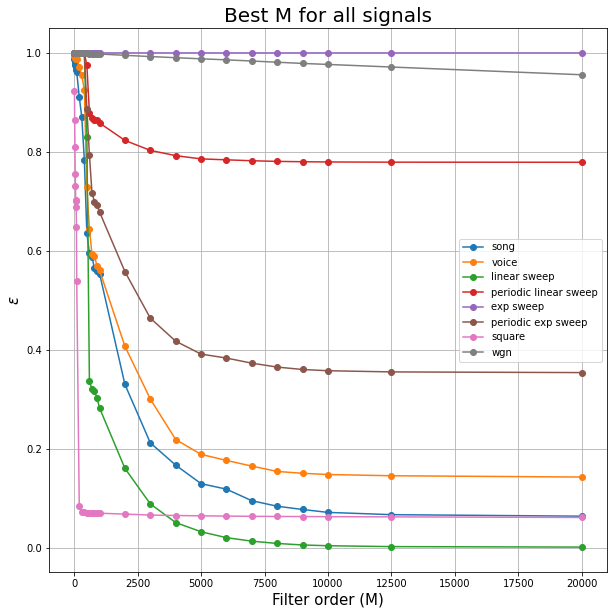

In [7]:
plt.figure(figsize=(10,10))
for k in errors_dict:
    ep = errors_dict[k]['epsilon']
    plt.plot(order, ep, label=k, marker='o')
plt.legend()
plt.ylabel('$\epsilon$', fontsize=15)
plt.xlabel('Filter order (M)', fontsize=15)
plt.title('Best M for all signals', fontsize=20)
plt.grid(which='both', axis='both')
plt.show()

En la comparativa anterior se observa como el barrido lineal en frecuencia es el que obtiene un menor error normalizado (lo que redunda en un mejor desempeño), en comparación al resto de las señales de excitación. En relación a la estimación usando ruido blanco gaussiano se destaca que, tal como fue previsto en el análisis correspondiente, el error en la estimación es casi total, debido a la presencia de componente estocásticas en la misma. Contrario a lo esperado, el barrido exponencial en frecuencia presenta un alto grado de error. Esto podría ser consecuencia de la presencia de distorsión armónica provocada por el parlante usado al momento de reproducir la pista. 

In [8]:
print('Lowest norm error is {:0.4f} achieved with the following parameters:'.format(best['epsilon']))
print('audio = {}'.format(best['type']))
print('order = {}'.format(best['order']))

Lowest norm error is 0.0017 achieved with the following parameters:
audio = linear sweep
order = 20000


# Estimación de respuestas impulsivas
En este apartado se adopta el orden óptimo $M=20000$ (estimado con el barrido lineal en frecuencia) y se procede a calcular la estimación de la respuesta impulsiva de la habitación, para cada señal.

## Fragmento de canción

epsilon = 0.0641


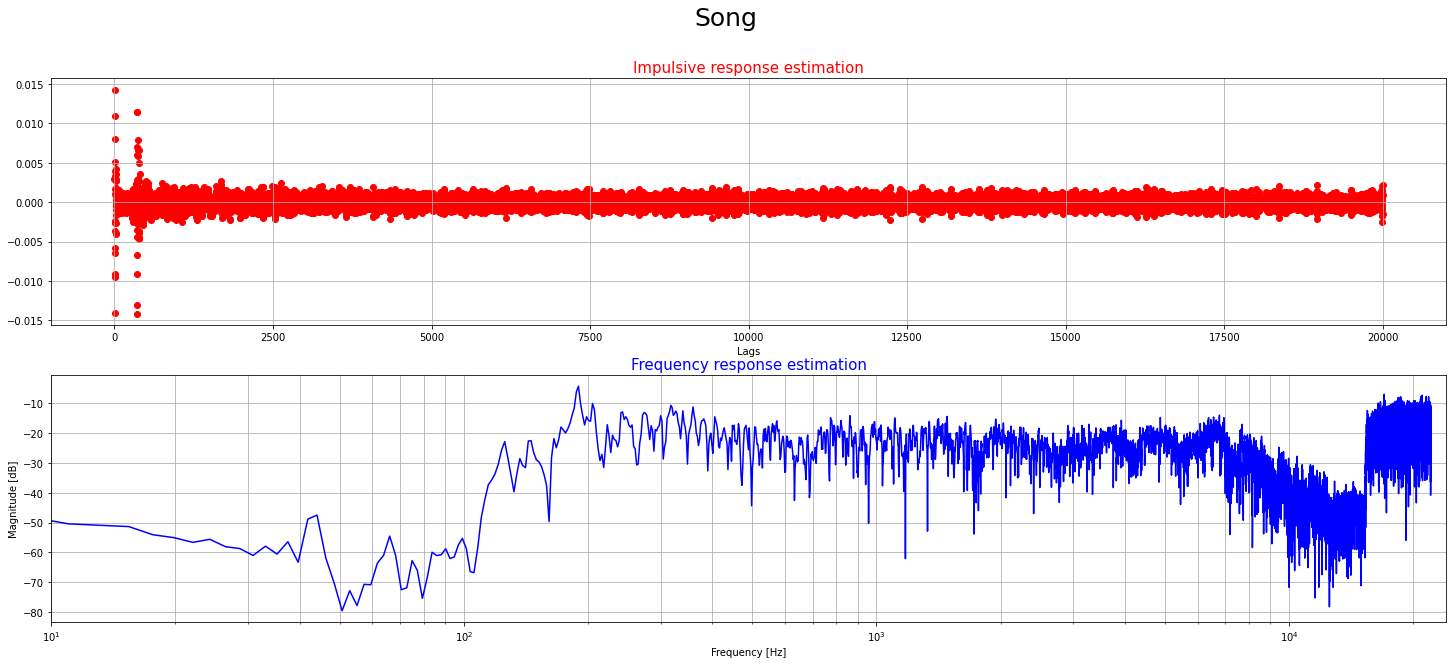

In [9]:
estimate_response(original_base + audios_dict['song'], record_base + audios_dict['song'], 20000, 'Song')

## Señal de voz

epsilon = 0.1432


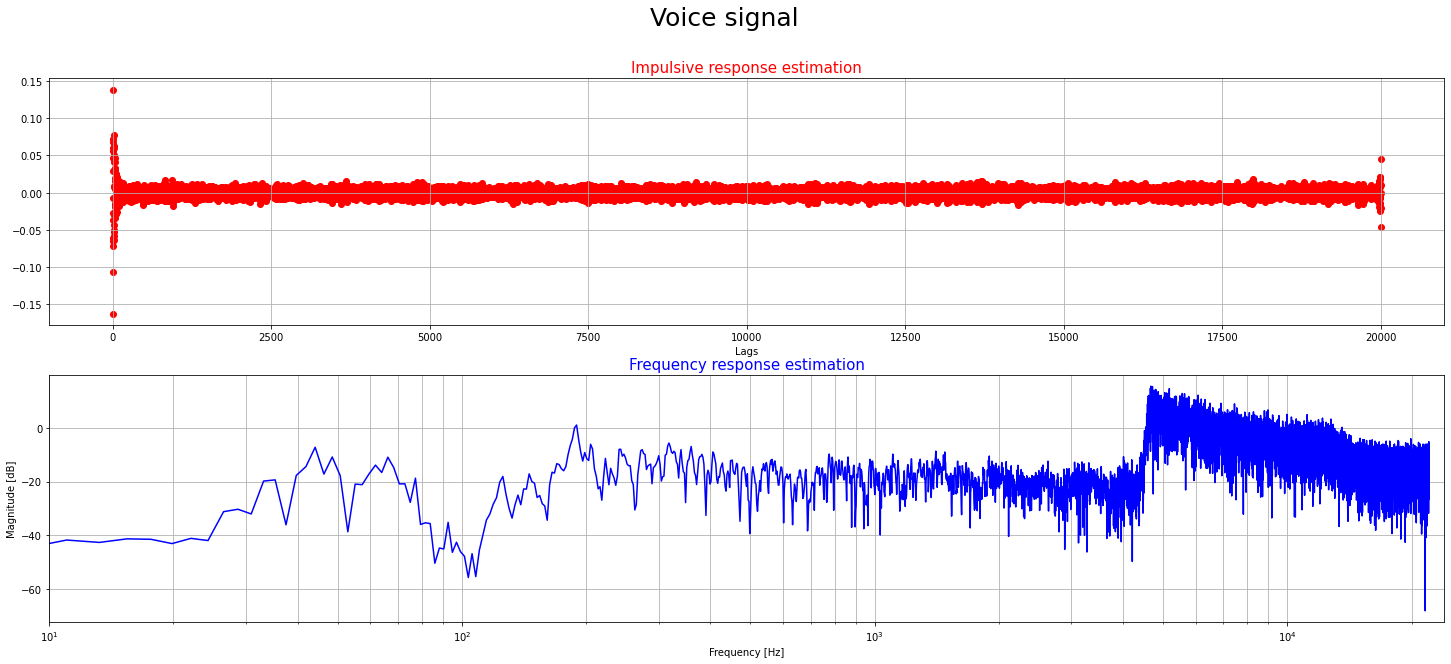

In [10]:
estimate_response(original_base + audios_dict['voice'], record_base + audios_dict['voice'], 20000, 'Voice signal')

## Señal rectangular

epsilon = 0.0615


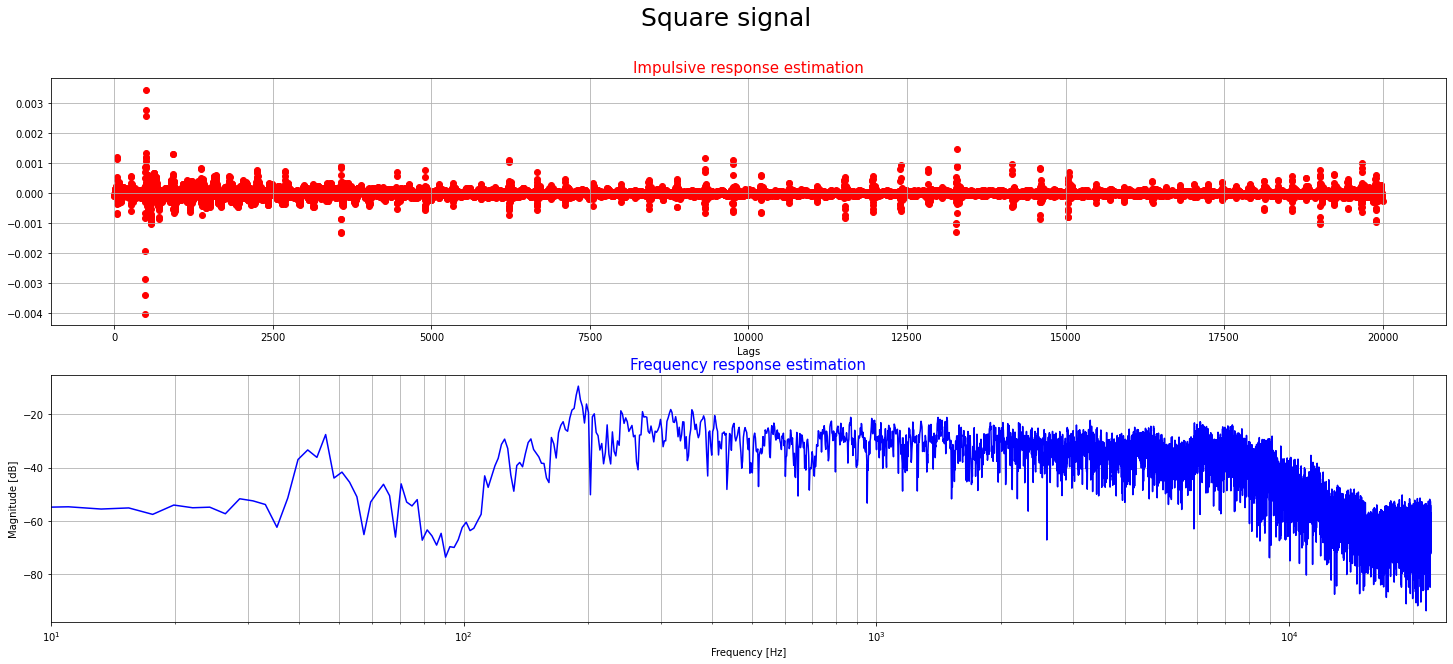

In [11]:
estimate_response(original_base + audios_dict['square'], record_base + audios_dict['square'], 20000, 'Square signal')

## Barrido lineal en frecuencia

epsilon = 0.0017


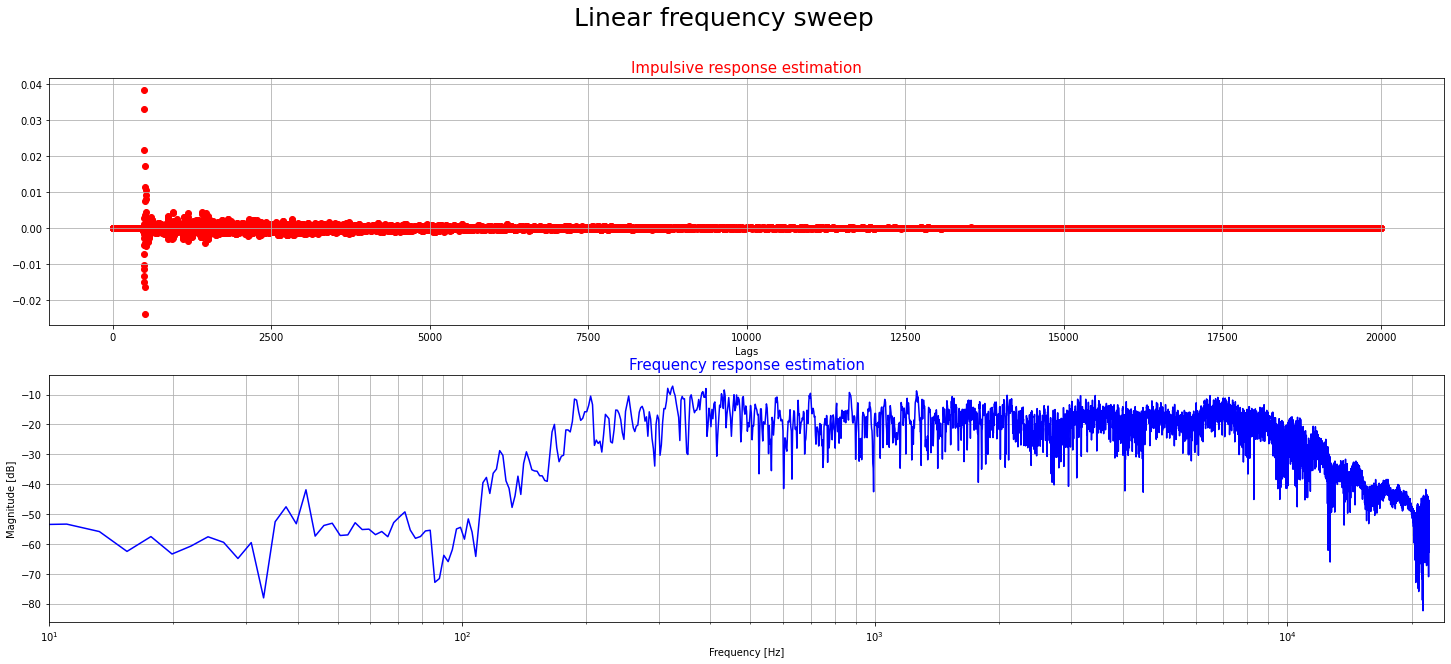

In [12]:
estimate_response(original_base + audios_dict['linear sweep'], record_base + audios_dict['linear sweep'], 20000, 'Linear frequency sweep')

## Barrido exponencial en frecuencia

epsilon = 1.0000


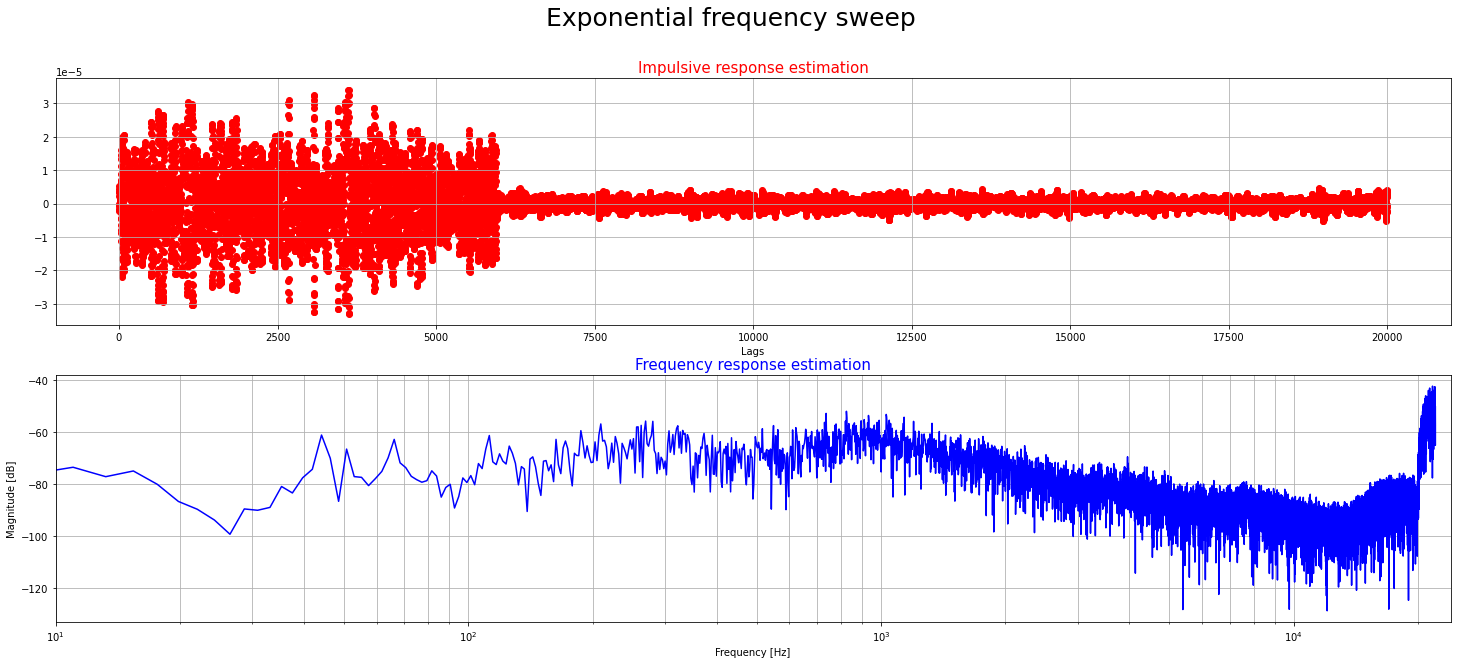

In [13]:
estimate_response(original_base + audios_dict['exp sweep'], record_base + audios_dict['exp sweep'], 20000, 'Exponential frequency sweep')

## Ruido blanco gaussiano

epsilon = 0.9559


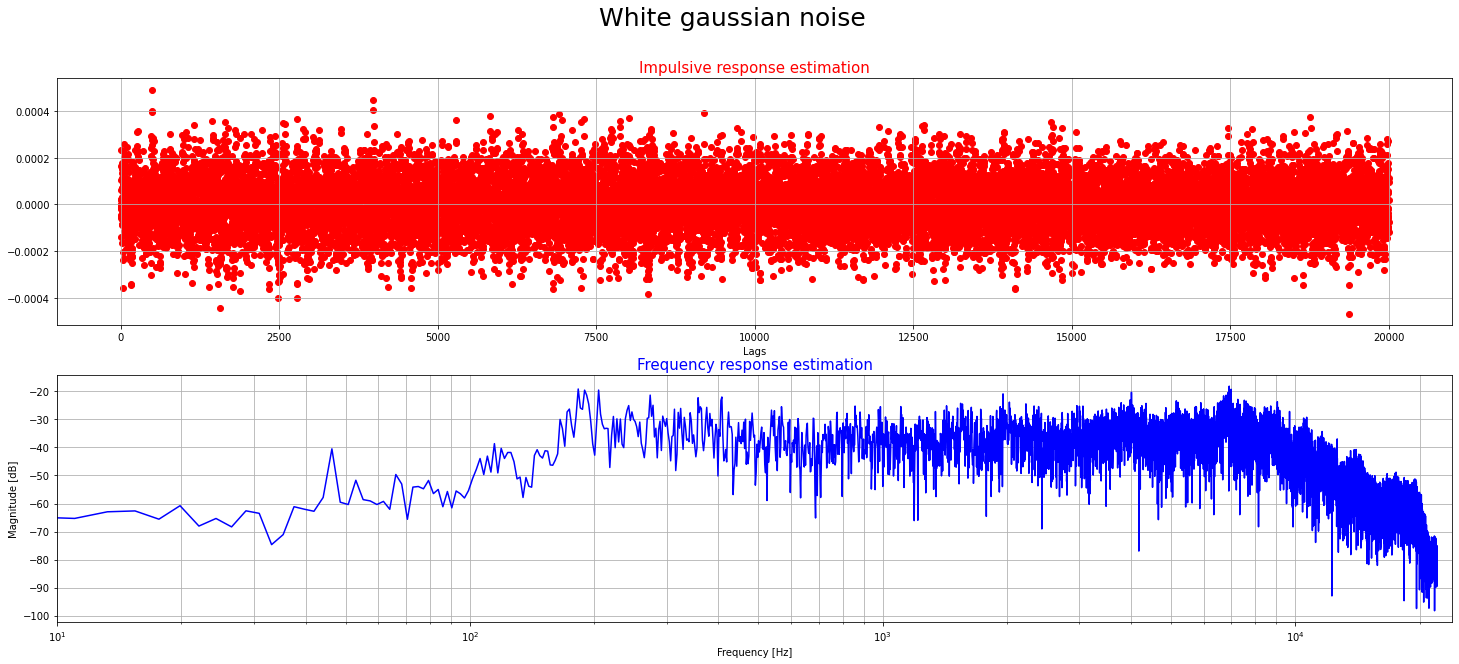

In [14]:
estimate_response(original_base + audios_dict['wgn'], record_base + audios_dict['wgn'], 20000, 'White gaussian noise')

Observando los gráficos anteriores, podemos concluir que en las estimaciones realizadas con el barrido lineal, el fragmento de canción, y la señal cuadrada las respuestas en frecuencia obtenidas responden a un esquema pasabanda, con frecuencias de corte en 200Hz y 8kHz respectivamente. Por otro lado, cabe aclarar que la respuesta impulsiva estimada con la señal cuadrada presenta artefactos cuasi-periódicos. Finalmente, las dos señales con peor desempeño en su estimación (ruido blanco y barrido exponencial en frecuencia)  presentan una gran cantidad de componentes estocásticas que no permitieron estimar correctamente la respuesta del sistema físico.

## Síntesis de la respuesta ante el fragmento de canción
Por último, se estima la respuesta del sistema físico filtrando la señal de excitación utilizada (en este caso, el fragmento de canción) con un filtro FIR constituido por los coeficientes óptimos estimados con anterioridad.  

In [15]:
o_rate, original = wavfile.read(original_base + audios_dict['song'])
r_rate, recorded = wavfile.read(record_base + audios_dict['song']) 

output_signal = np.int16(sps.oaconvolve(original, wo))
wavfile.write(base + '/assets/output/filtered_song2.wav', r_rate, output_signal)

In [19]:
print('Original signal')
Audio(original_base + audios_dict['song'])

Original signal


In [20]:
print('Estimated room response')
Audio(base + '/assets/output/filtered_song2.wav')

Estimated room response


In [21]:
print('Recorded room response')
Audio(record_base + audios_dict['song'])

Recorded room response


Escuchando las pistas anteriores, se aprecia que la estimación de la respuesta del sistema físico presenta un recorte en bajas frecuencias, en comparación con la respuesta grabada en la habitación.